In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import torch
from rpasim.ode import AB
from rpasim.env import DifferentiableEnv
import matplotlib.pyplot as plt

from rpasim.style import set_style
set_style()

# Compare grid widths

Compare trajectories from coarse grid (20 steps) vs fine grid (100 steps)

In [22]:
# Setup AB ODE
differentiable_params = torch.tensor([1.0, 0.0, -0.2])
fixed_params = torch.tensor([10.0, 1.0])
ab_ode = AB(differentiable_params, fixed_params)

x0 = torch.tensor([1.0, 0.5])
T = 10.0

def reward_fn(state):
    return -torch.norm(state)

In [23]:
# Create envs with different grid widths
# Coarse: 20 steps (dt=0.5), grid at 0, 0.5, 1, ..., 10
env_coarse = DifferentiableEnv(
    initial_ode=ab_ode,
    reward_fn=reward_fn,
    initial_state=x0,
    time_horizon=T,
    n_reward_steps=20,
)

# Fine: 100 steps (dt=0.1), grid at 0, 0.1, 0.2, ..., 10
env_fine = DifferentiableEnv(
    initial_ode=ab_ode,
    reward_fn=reward_fn,
    initial_state=x0,
    time_horizon=T,
    n_reward_steps=100,
)

# Run both
env_coarse.reset()
env_coarse.step((ab_ode, T))

env_fine.reset()
env_fine.step((ab_ode, T))

# Get trajectories
times_coarse, states_coarse, _ = env_coarse.get_trajectory()
times_fine, states_fine, _ = env_fine.get_trajectory()

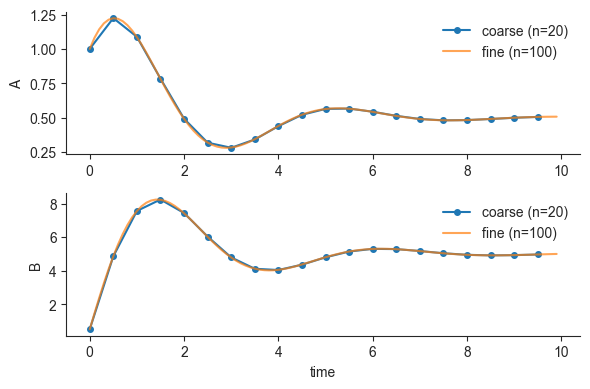

In [24]:
# Plot both trajectories on same axes
fig, axes = plt.subplots(2, 1, figsize=(6, 4))

# Plot A
axes[0].plot(times_coarse.detach().numpy(), states_coarse[:, 0].detach().numpy(), 
             'o-', label='coarse (n=20)', markersize=4)
axes[0].plot(times_fine.detach().numpy(), states_fine[:, 0].detach().numpy(), 
             '-', alpha=0.7, label='fine (n=100)')
axes[0].set_ylabel('A')
axes[0].legend(frameon=False, bbox_to_anchor=(1, 1))

# Plot B
axes[1].plot(times_coarse.detach().numpy(), states_coarse[:, 1].detach().numpy(), 
             'o-', label='coarse (n=20)', markersize=4)
axes[1].plot(times_fine.detach().numpy(), states_fine[:, 1].detach().numpy(), 
             '-', alpha=0.7, label='fine (n=100)')
axes[1].set_xlabel('time')
axes[1].set_ylabel('B')
axes[1].legend(frameon=False, bbox_to_anchor=(1, 1))

import seaborn as sns
sns.despine(ax=axes[0])
sns.despine(ax=axes[1])

plt.tight_layout()
plt.show()

In [25]:
# Compute differences at shared grid points
matches = []
for t_coarse in times_coarse:
    time_diffs = torch.abs(times_fine - t_coarse)
    idx_fine = torch.argmin(time_diffs)
    if time_diffs[idx_fine] < 0.01:
        matches.append(idx_fine.item())

states_fine_matched = states_fine[matches]
state_diffs = torch.norm(states_coarse - states_fine_matched, dim=1)

print(f"Max difference at shared points: {state_diffs.max().item():.4f}")
print(f"Mean difference at shared points: {state_diffs.mean().item():.4f}")

Max difference at shared points: 0.0189
Mean difference at shared points: 0.0063
